In [1]:
from functools import partial

import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dynamical_systems.continuous import AbstractODE, Lorenz63, solve_ode, TangentODE
from dynamical_systems.dataset import TimeSeriesDataset
from dynamical_systems.linalg import gram_schmidt
from dynamical_systems.metrics import lyapunov_gr
from dynamics_discovery.models import NeuralODE
from jaxtyping import Array, Float
from matplotlib_utils.axes_setters import set_labels
from dynamics_discovery.preprocessing import split_into_chunks

jax.config.update("jax_enable_x64", True)

In [2]:
dataset_loaded = TimeSeriesDataset.load("./data/lorenz.hdf5")

batch_length = 200


def standardize(x: Array, axis: int = 0) -> Array:
    return (x - jnp.mean(x, axis=axis)) / jnp.std(x, axis=axis)


u_train = standardize(dataset_loaded.u[0])

t_train_batched, _ = split_into_chunks(dataset_loaded.t, batch_length)
u_train_batched, _ = split_into_chunks(u_train, batch_length)
print(t_train_batched.shape)
print(u_train_batched.shape)

(500, 200)
(500, 200, 3)


In [3]:
model = NeuralODE(3, 32, 3, key=0)

In [5]:
lya_local, sol = eqx.filter_vmap(lyapunov_gr, in_axes=(None, 0, 0))(
    model, u_train_batched[:, 0], t_train_batched
)
lya_mean = jnp.mean(lya_local, axis=0)

In [6]:
sol.shape

(500, 200, 3)

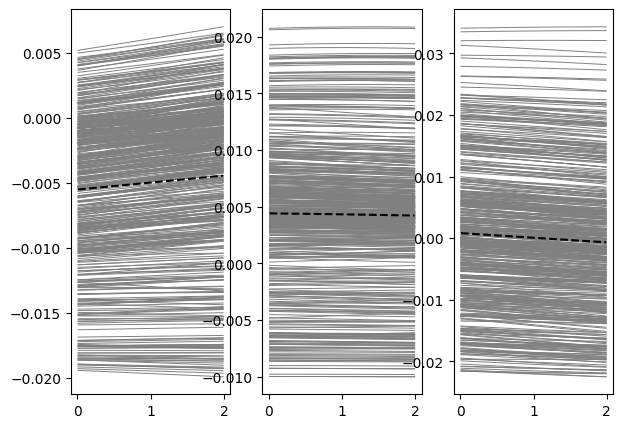

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(7, 5), sharex=True)
for i, ax in enumerate(axes):
    for lya_i in lya_local:
        ax.plot(t_train_batched[0], lya_i[:, i], color="gray", linewidth=0.7)
    ax.plot(t_train_batched[0], lya_mean[:, i], "--", color="black")

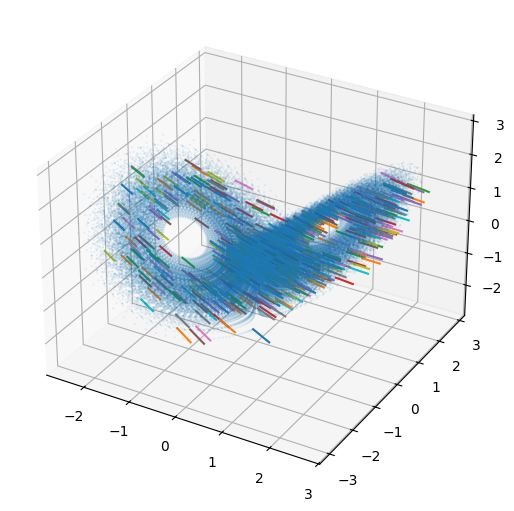

In [8]:
fig, ax = plt.subplots(
    1, 1, figsize=(8, 5), constrained_layout=True, subplot_kw={"projection": "3d"}
)
ax.scatter(*u_train.T, s=0.2, alpha=0.1)
for sol_i in sol:
    ax.plot(*sol_i.T)

In [9]:
from collections.abc import Callable


class ConditionalTangentODE(AbstractODE):
    ode: AbstractODE

    @property
    def dim(self) -> int:
        return self.ode.dim * (self.ode.dim + 1)

    def rhs(
        self,
        t,
        u: tuple[Float[Array, " dim"], Float[Array, "dim dim"]],
        control_fn: Callable,
    ):
        x, Tx = u
        x_ctrl = control_fn(t)

        def rhs_ode(x_):
            return self.ode.rhs(t, x_, None)

        @partial(jax.vmap, in_axes=(None, -1), out_axes=(None, -1))
        def rhs_jac(x_, Tx_i):
            return jax.jvp(rhs_ode, (x_,), (Tx_i,))

        dx = rhs_ode(x)
        _, dTx = rhs_jac(x_ctrl, Tx)

        return dx, dTx

In [18]:
def conditional_lyapunov_gr(
    ode: AbstractODE,
    u0: Float[Array, " dim"],
    t: Float[Array, " time_perturb"],
    coeffs,
    solver=dfx.Tsit5(),
    rtol=1e-6,
    atol=1e-6,
    **diffeqsolve_kwargs,
) -> tuple[Float[Array, "time_perturb dim"], Float[Array, "time_perturb dim"]]:
    """Evaluate the local Lyapunov exponent by integrating the tangent dynamics
    and performing Gram-Schmidt orthonormalization every time step to prevent the
    the tangent vectors from collapsing onto the largest eigenvector direction."""
    ode_tangent = ConditionalTangentODE(ode)
    u0_tangent = (u0, jnp.identity(ode.dim))
    log_norm_sum = jnp.zeros(ode.dim)

    carry = t[0], u0_tangent, log_norm_sum
    spline = dfx.CubicInterpolation(t, coeffs)

    def _inner(carry, t1):
        t0, u0_tangent_, log_norm_sum0 = carry
        u1, u1_tangent = dfx.diffeqsolve(
            dfx.ODETerm(ode_tangent.rhs),
            solver,
            t0,
            t1,
            None,
            u0_tangent_,
            spline.evaluate,
            saveat=dfx.SaveAt(t1=True),
            stepsize_controller=dfx.PIDController(rtol=rtol, atol=atol),
            **diffeqsolve_kwargs,
        ).ys
        u1_tangent_gr, u1_tangent_norm = gram_schmidt(u1_tangent[0])
        log_norm_sum1 = log_norm_sum0 + jnp.log(u1_tangent_norm)
        carry_new = t1, (u1[0], u1_tangent_gr), log_norm_sum1
        return carry_new, (log_norm_sum1, u1[0])

    _, (log_norm_sums, u_vals) = jax.lax.scan(_inner, carry, t[1:])
    log_norm_sums = jnp.concatenate(
        [jnp.expand_dims(log_norm_sum, 0), log_norm_sums], axis=0
    )
    u_vals = jnp.concatenate([jnp.expand_dims(u0, 0), u_vals], axis=0)
    Dt = jnp.expand_dims(t - t[0], axis=-1)
    return log_norm_sums / Dt, u_vals


In [19]:
coeffs_batched = eqx.filter_vmap(dfx.backward_hermite_coefficients)(
    t_train_batched, u_train_batched
)

In [20]:
lya_cond, u = eqx.filter_vmap(conditional_lyapunov_gr, in_axes=(None, 0, 0, 0))(
    model, u_train_batched[:, 0], t_train_batched, coeffs_batched
)

In [21]:
lya_cond_mean = jnp.mean(lya_cond, axis=0)

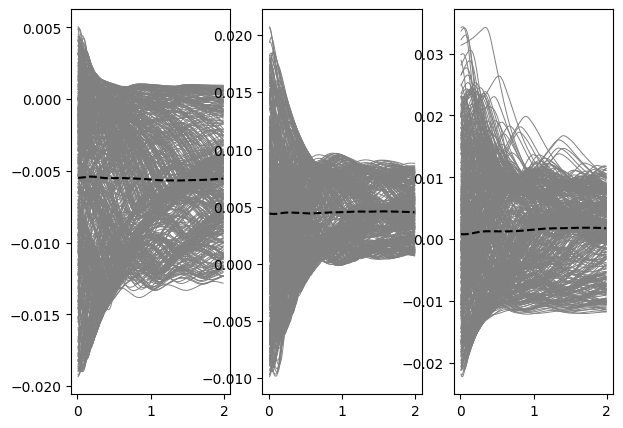

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(7, 5), sharex=True)
for i, ax in enumerate(axes):
    for lya_i in lya_cond:
        ax.plot(t_train_batched[0], lya_i[:, i], color="gray", linewidth=0.7)
    ax.plot(t_train_batched[0], lya_cond_mean[:, i], "--", color="black")